Importing Libraries

In [2]:
import os
import numpy as np
import librosa
import librosa.display
import soundfile as sf
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

Setting Datapaths

In [ ]:
DATASET_ROOT = "./LA/LA"
TRAIN_FOLDER = os.path.join(DATASET_ROOT, "ASVspoof2019_LA_train")
DEV_FOLDER = os.path.join(DATASET_ROOT, "ASVspoof2019_LA_dev")
PROTOCOL_FILE = os.path.join(DATASET_ROOT, "ASVspoof2019_LA_cm_protocols", "ASVspoof2019.LA.cm.train.trn.txt")

Loading Dataset

In [ ]:
def load_dataset(folder, protocol_file):
    features, labels = [], []
    with open(protocol_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            file_name, label = parts[1], parts[-1]
            file_path = os.path.join(folder, "flac", file_name + ".flac")
            if os.path.exists(file_path):
                features.append(extract_features(file_path))
                labels.append(label)
    return np.array(features), np.array(labels)

Extracting Features

In [ ]:
def extract_features(file_path, n_mfcc=20):
    y, sr = librosa.load(file_path, sr=16000)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs, axis=1)  # Use mean of MFCCs over time

Loading Train Data

In [ ]:
X_train, y_train = load_dataset(TRAIN_FOLDER, PROTOCOL_FILE)

c:\Users\varchasva\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


Saving Progress to Pickle File

In [ ]:
import pickle
pickle_file_path = "train_data.pkl"

with open(pickle_file_path, 'wb') as file:
    pickle.dump({'X_train': X_train, 'y_train': y_train}, file)

print(f"Data successfully saved to {pickle_file_path}")

Data successfully saved to train_data.pkl


Plotting Class Distribution

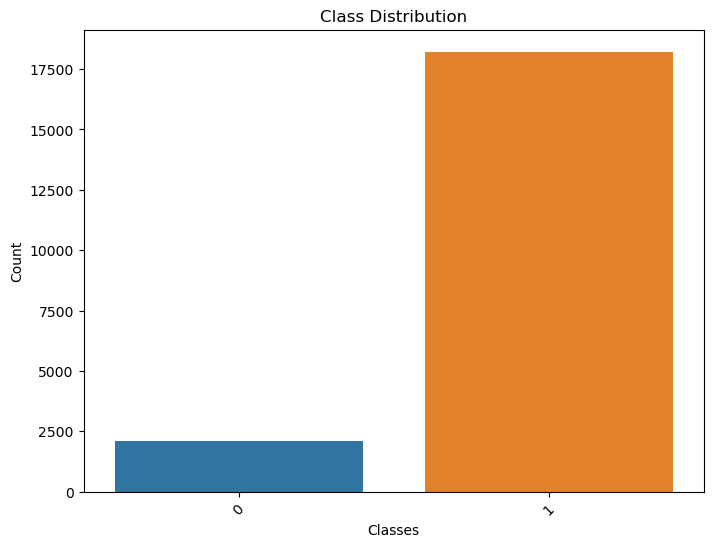

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train)
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Plotting Feature Distribution

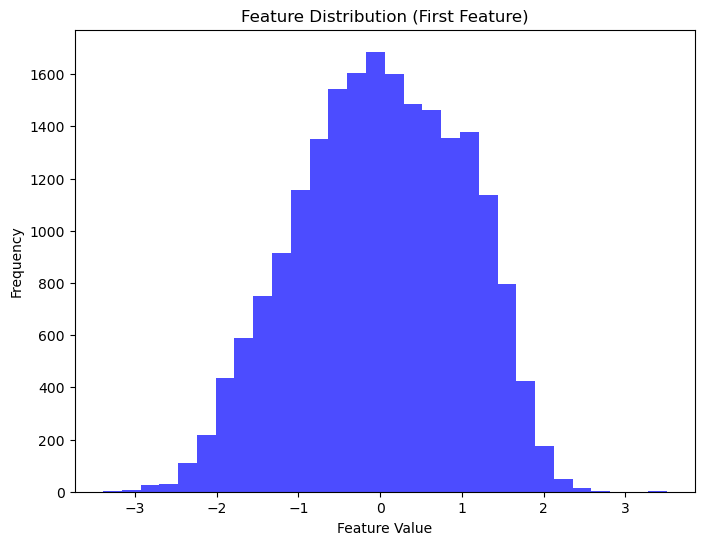

In [25]:
# Feature Distribution
plt.figure(figsize=(8, 6))
plt.hist(X_train[:, 0], bins=30, color='blue', alpha=0.7)
plt.title("Feature Distribution (First Feature)")
plt.xlabel("Feature Value")
plt.ylabel("Frequency")
plt.show()

Visualising a Single Sample

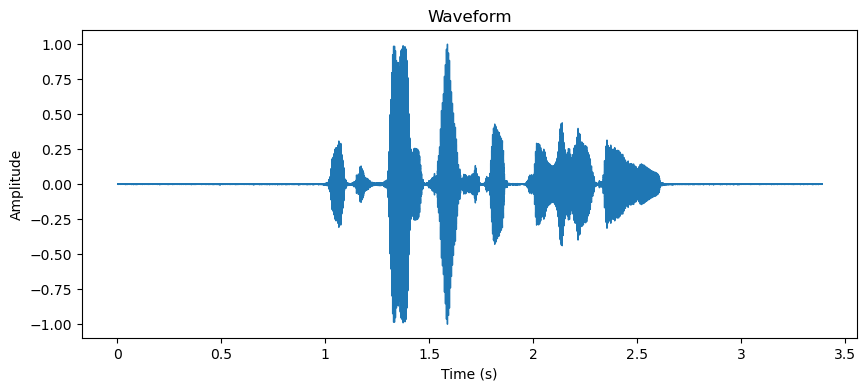

In [26]:
sample_file = r'LA\LA\ASVspoof2019_LA_train\flac\LA_T_1003665.flac'  # Example File
audio, sr = librosa.load(sample_file, sr=None)

# Plot Waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

Plotting MEL Spectogram

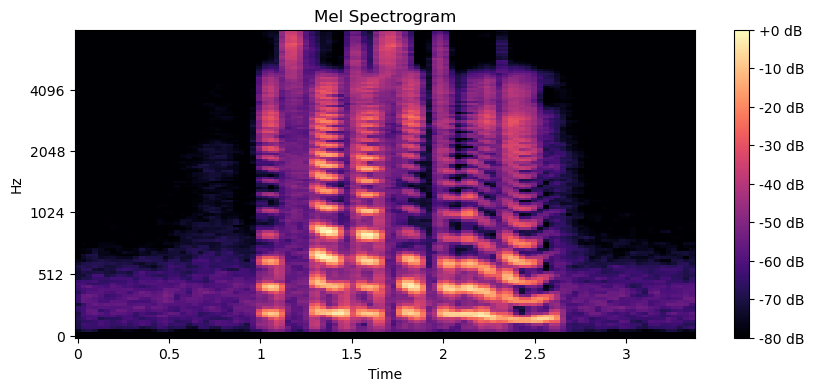

In [27]:
# Plot Spectrogram
plt.figure(figsize=(10, 4))
spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), sr=sr, x_axis='time', y_axis='mel')
plt.title("Mel Spectrogram")
plt.colorbar(format='%+2.0f dB')
plt.show()

Label Encoding

In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

Normalising Features

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

Splitting into Train & Test

In [ ]:
# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Training on SVM Classifier

In [ ]:
svm = SVC(kernel='rbf', C=1.0, gamma='scale')
svm.fit(X_train, y_train)

SVC()

Evaluating Model

In [ ]:
y_pred = svm.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))


Accuracy: 0.9806934594168637
              precision    recall  f1-score   support

    bonafide       0.95      0.85      0.90       505
       spoof       0.98      0.99      0.99      4571

    accuracy                           0.98      5076
   macro avg       0.97      0.92      0.94      5076
weighted avg       0.98      0.98      0.98      5076



Grid-Search CV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'], 
    'gamma': ['scale', 'auto'],  
    'degree': [2, 3, 4]
}


svm = SVC()

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

from sklearn.metrics import accuracy_score, classification_report
print("Accuracy on Validation Set:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.9837469477172623
Accuracy on Validation Set: 0.9887706855791962
              precision    recall  f1-score   support

    bonafide       0.95      0.93      0.94       505
       spoof       0.99      0.99      0.99      4571

    accuracy                           0.99      5076
   macro avg       0.97      0.96      0.97      5076
weighted avg       0.99      0.99      0.99      5076



Plotting Results

Plotting Confusion Matrix

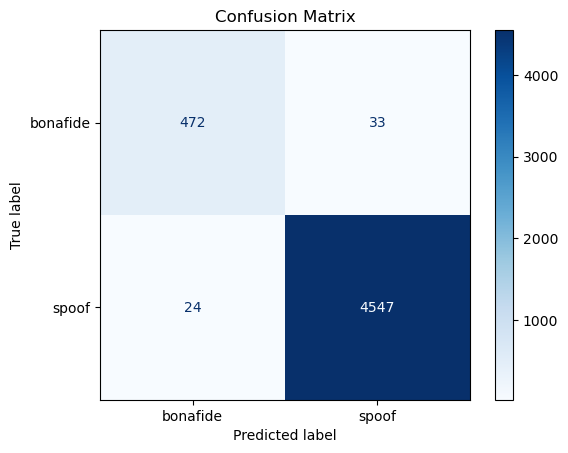

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Bar Plot for Precision, Recall, and F1-Score

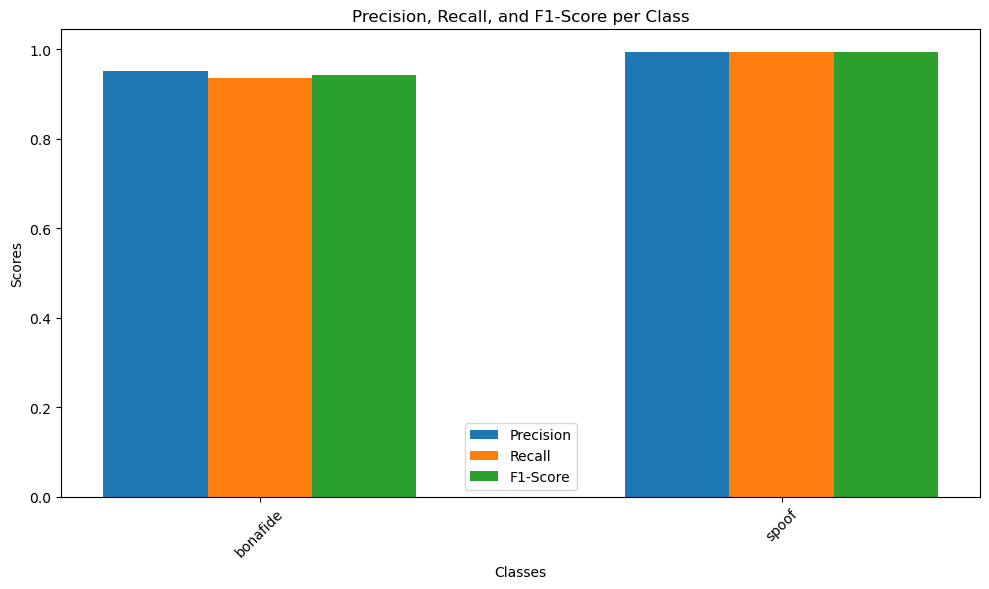

In [31]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, y_pred, average=None)
x_labels = label_encoder.classes_

x = range(len(x_labels))
plt.figure(figsize=(10, 6))
plt.bar(x, precision, width=0.2, label='Precision', align='center')
plt.bar([p + 0.2 for p in x], recall, width=0.2, label='Recall', align='center')
plt.bar([p + 0.4 for p in x], f1_score, width=0.2, label='F1-Score', align='center')
plt.xticks([p + 0.2 for p in x], x_labels, rotation=45)
plt.xlabel("Classes")
plt.ylabel("Scores")
plt.title("Precision, Recall, and F1-Score per Class")
plt.legend()
plt.tight_layout()
plt.show()